# Setup

In [ ]:
# setup to see the execution time in each cell

!pip install ipython-autotime
!pip install directory_structure
!curl https://colab.chainer.org/install | sh -
%load_ext autotime

     |████████████████████████████████| 175 kB 12.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=13b298f2f8975c17339bd7a4d48767af58e9ec530bc1c906d5b15702afa0e15c
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   6528      0 --:--:-- --:--:-- --:--:--  6528
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
+ 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 16.6 s (started: 2022-05-10 21:54:12 +00:00)


In [ ]:
import pandas as pd
import os
import glob
import PIL
from PIL import Image
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

time: 1.56 s (started: 2022-05-10 21:54:28 +00:00)


## No Aug

In [ ]:
ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

DATASET_01 = ROOT_DIR + "/datasets/01_MRI/Brain_tumor_images"
DATASET_01_TRAIN = DATASET_01 + "/train"
DATASET_01_TEST = DATASET_01 + "/test"

time: 5.48 ms (started: 2022-05-10 22:00:02 +00:00)


## Aug

In [ ]:
# ROOT_DIR = "/content/drive/MyDrive/Spring 2022/DTSC 870/Code" # HC Directory
# # ROOT_DIR = "/content/drive/MyDrive/DTSC 870/Code" #MT Directory

# DATASET_01 = ROOT_DIR + "/datasets/01_MRI"
# DATASET_01_TRAIN = DATASET_01 + "/Aug_train"
# DATASET_01_TEST = DATASET_01 + "/Aug_test"

time: 9.38 ms (started: 2022-05-10 22:00:03 +00:00)


# Preprocessing

In [ ]:
from directory_structure import Tree

os.chdir(DATASET_01)
print(Tree(os.getcwd()))

📂 Brain_tumor_images
|_📁 train
|_📁 test
time: 18.5 ms (started: 2022-05-10 22:00:03 +00:00)


In [ ]:
#Figuring out loading images to preprocess

def get_total_train_num(dir):
  return len(glob.glob(dir))


def get_data_df(dir):
  # modified code from: https://www.kaggle.com/namgalielei/simple-load-images-and-count-number-of-each-class

  train_df = pd.DataFrame()

  trainset = glob.glob(dir)

  train_df['file'] = [img.split("/")[-1] for img in trainset]
  train_df['class'] = [img.split("/")[-2] for img in trainset]

  return train_df


def generate_set(df, dir):

  # new_df = pd.DataFrame()
  pixels = []
  class_ = []

  # trainset = glob.glob(dir)
  for i in range(len(df.index)):
    # get the absolute img path
    # e.g., Brain_tumor_images/<train or test>/<class label>/<file name>
    path = dir + "/" + df.iloc[i]["class"] + "/" +df.iloc[i]["file"]
    # print(img)
    img = Image.open(path)
    # print("Img: {} \tClass: {}".format(np.array(img).flatten(), df.iloc[i]["class"]))
    pixels.append(cp.asnumpy(cp.array(img)).flatten())
    # pixels.append(np.array(img))

    # y_true encoding here
    if df.iloc[i]["class"] == "Normal":
      class_.append(0)
    else:
      class_.append(1)

  # train_df['file'] = [img.split("/")[-1] for img in trainset]
  # train_df['class'] = [img.split("/")[-2] for img in trainset]

  # return train_df
  return pixels, class_

time: 42.2 ms (started: 2022-05-10 22:00:03 +00:00)


In [ ]:
mri_df_train = get_data_df(DATASET_01_TRAIN+"/*/*.jpg")
mri_df_test = get_data_df(DATASET_01_TEST+"/*/*.jpg")

x_train, y_train = generate_set(mri_df_train, DATASET_01_TRAIN)
x_test, y_test = generate_set(mri_df_test, DATASET_01_TEST)

time: 1min 8s (started: 2022-05-10 22:00:03 +00:00)


In [ ]:
print("x_train shape: {}\ny_train shape: {}\nx_test shape: {}\ny_test shape: {}".format(np.array(x_train).shape, np.array(y_train).shape, np.array(x_test).shape, np.array(y_test).shape))

x_train shape: (279, 196608)
y_train shape: (279,)
x_test shape: (121, 196608)
y_test shape: (121,)
time: 24.3 ms (started: 2022-05-10 22:01:12 +00:00)


## Get the dimension of the data

In [ ]:
# print(len(mri_df_train))
# print(len(mri_df_test))
mri_df_train.head()
img = Image.open(DATASET_01_TRAIN +"/"+ mri_df_train['class'].iloc[0]+"/"+ mri_df_train['file'].iloc[0])
w, h = img.size

print("Width: {}, Height: {}".format(w, h))

img = np.array(img)

# Code ref: https://gist.github.com/liuhh02/ade48d822139006f98d8f05681209ab6

# find number of channels
if img.ndim == 2:
    channels = 1
    print("image has 1 channel")
else:
    channels = img.shape[-1]
    print("image has", channels, "channels")

Width: 256, Height: 256
image has 3 channels
time: 12.2 ms (started: 2022-05-10 22:01:12 +00:00)


In [ ]:
from sklearn.preprocessing import StandardScaler

time: 562 µs (started: 2022-05-10 22:01:12 +00:00)


In [ ]:
sc = StandardScaler()

x_train_sc = sc.fit_transform(np.array(x_train))
x_test_sc = sc.transform(np.array(x_test))

time: 915 ms (started: 2022-05-10 22:01:12 +00:00)


# Model

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.svm import SVC
from numpy import mean

time: 1.94 ms (started: 2022-05-10 22:01:13 +00:00)


In [ ]:
model = SVC(random_state=1)

time: 633 µs (started: 2022-05-10 22:01:13 +00:00)


In [ ]:
model.fit(x_train_sc, y_train)

y_pred = model.predict(x_test_sc)

uw_acc = balanced_accuracy_score(y_test, y_pred)
print("The unweighted accuracy is: {}".format(uw_acc))

The unweighted accuracy is: 0.725613154960981
time: 28.6 s (started: 2022-05-10 22:01:13 +00:00)


In [ ]:
w_acc = accuracy_score(y_test, y_pred)
print("The weighted accuracy is: {}".format(w_acc))

The weighted accuracy is: 0.743801652892562
time: 5.95 ms (started: 2022-05-10 22:01:42 +00:00)


# Analysis

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

time: 1.31 ms (started: 2022-05-10 22:01:42 +00:00)


## Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


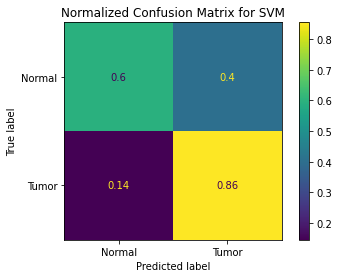

time: 15.6 s (started: 2022-05-10 22:01:42 +00:00)


In [ ]:
disp = plot_confusion_matrix(model, x_test_sc, y_test, display_labels=["Normal", "Tumor"], normalize='true')
plt.title("Normalized Confusion Matrix for SVM")
confM = disp.confusion_matrix
plt.show()

## Accuracy Per Class

In [ ]:
print("The variance: 80%")
row1_sum = np.array(confM[0]).sum()
row2_sum = np.array(confM[1]).sum()

acc_Normal = (confM[0][0] / row1_sum)*100
acc_Tumor = (confM[1][1] / row2_sum)*100

print(f"Normal accuracy: {acc_Normal}, Tumor accuracy: {acc_Tumor}")
print("")

The variance: 80%
Normal accuracy: 59.61538461538461, Tumor accuracy: 85.5072463768116

time: 4.11 ms (started: 2022-05-10 22:01:58 +00:00)


## ROC

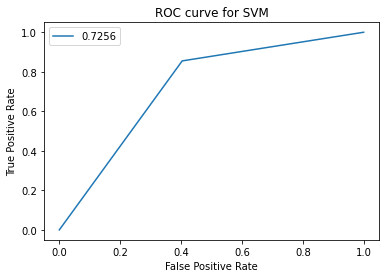

time: 15.4 s (started: 2022-05-10 22:01:58 +00:00)


In [ ]:
y_pred = model.predict(x_test_sc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = np.round_(auc(fpr, tpr), decimals=4)
plt.plot(fpr, tpr, label=roc_auc)

plt.title("ROC curve for SVM")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend()
plt.show()

## Classification Report

In [ ]:
target_names = ['Normal', 'Tumor']
print("Classification report for SVM")
y_pred = model.predict(x_test_sc)
print(classification_report(y_test, y_pred, target_names=target_names))
print("\n\n")

Classification report for SVM
              precision    recall  f1-score   support

      Normal       0.76      0.60      0.67        52
       Tumor       0.74      0.86      0.79        69

    accuracy                           0.74       121
   macro avg       0.75      0.73      0.73       121
weighted avg       0.75      0.74      0.74       121




time: 15.3 s (started: 2022-05-10 22:02:13 +00:00)
